In [1]:
from src.models.MultiModal import MultiModalModel, MultiModalModel_GB
from torch.utils.data import DataLoader
import os, torch

if(torch.cuda.device_count() >= 1):
    device = "cuda:2"
else:
    device = 'cpu'
    
ts_cols = [
    '\\q95', '\\ipmhd', '\\kappa', '\\tritop', '\\tribot',
    '\\betap','\\betan','\\li', '\\WTOT_DLM03', #'\\ne_inter01', 
    '\\TS_NE_CORE_AVG', '\\TS_TE_CORE_AVG'
]

args_video = {
    "image_size" : 128, 
    "patch_size" : 16, 
    "n_frames" : 21, 
    "dim": 128, 
    "depth" : 4, 
    "n_heads" : 8, 
    "pool" : 'cls', 
    "in_channels" : 3, 
    "d_head" : 64, 
    "dropout" : 0.25,
    "embedd_dropout": 0.25, 
    "scale_dim" : 4,
}

args_0D = {
    "n_features" : len(ts_cols), 
    "feature_dims" : 128,
    "max_len" : 21, 
    "n_layers" : 4,
    "n_heads" : 8,
    "dim_feedforward":512, 
    "dropout" : 0.25,
}

model = MultiModalModel(
    2,
    21,
    args_video,
    args_0D
)

model.to(device)

save_best_dir = "./weights/Multi-Modal_clip_21_dist_1_Focal_RS_RW_best.pt"
model.load_state_dict(torch.load(save_best_dir))

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")



################# Probability curve generation process #################



/home/jinsukim/codes_for_study/research-predict-disruption/src/utils/utility.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ts_data[ts_cols] = self.scaler.fit_transform(self.ts_data[ts_cols].values)
100%|██████████| 795/795 [01:00<00:00, 13.21it/s]


time :  1339
prob :  1339
thermal quench :  5.342
current quench:  5.368


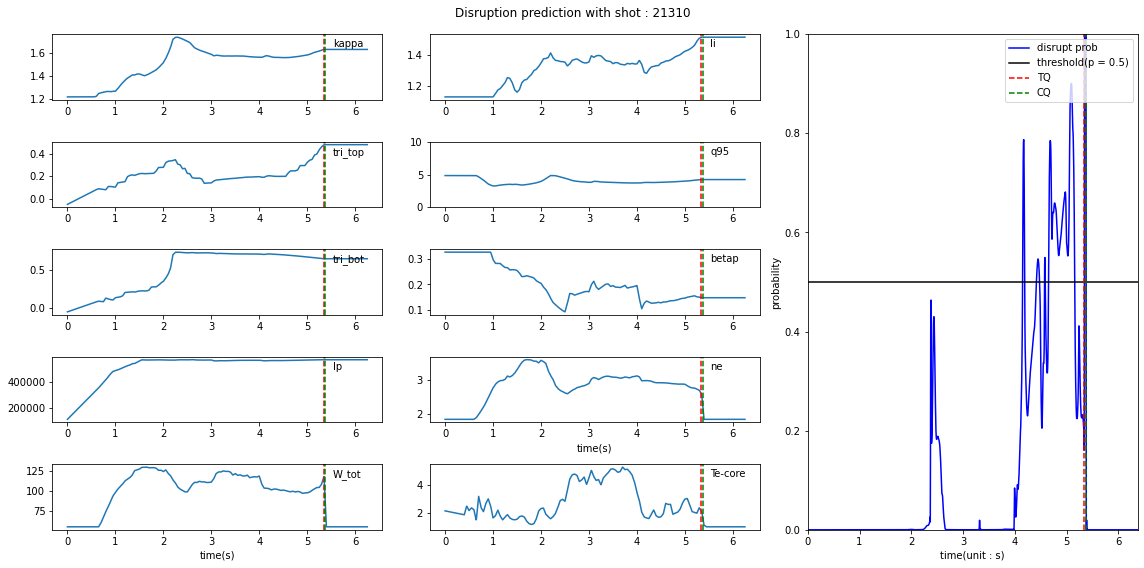

In [2]:
from src.utils.utility import generate_prob_curve_from_multi, MultiModalDataset

test_shot_num = 21310
print("\n################# Probability curve generation process #################\n")
time_x, prob_list = generate_prob_curve_from_multi(
    file_path = "./dataset/temp/{}".format(test_shot_num),
    model = model,
    device = device,
    save_dir = "./results/Multi-Modal_clip_21_dist_1_Focal_RS_RW_probs_curve.png",
    ts_data_dir = "./dataset/KSTAR_Disruption_ts_data_5ms.csv",
    ts_cols = ts_cols,
    shot_num = test_shot_num,
    vis_seq_len = 21,
    ts_seq_len = 21,
    dist = 1,
    dt = 1 / 210,
    scaler = None
)

In [3]:
import pandas as pd

ts_data = pd.read_csv("./dataset/KSTAR_Disruption_ts_data_5ms.csv")
ts_data.head()

,time,shot,\q95,\ipmhd,\kappa,\tritop,\tribot,\betap,\betan,\li,...,\TS_EDGE11:EDGE11_NE,\TS_EDGE12:EDGE12_NE,\TS_EDGE13:EDGE13_NE,\TS_EDGE14:EDGE14_NE,\TS_EDGE15:EDGE15_NE,\TS_NE_CORE_AVG,\TS_NE_EDGE_AVG,\TS_TE_CORE_AVG,\TS_TE_EDGE_AVG,frame_idx
0,0.000000,13074,6.415995,19338.836011,1.282146,0.523962,-0.057457,1.026884,1.17876,1.479425,...,0.0,0.0,0.0,0.0,0.0,0.066000,0.646001,0.841420,0.096789,0
1,0.004762,13074,6.415995,21811.813093,1.282146,0.523962,-0.055073,1.026884,1.17876,1.479425,...,0.0,0.0,0.0,0.0,0.0,0.069713,0.642311,0.846794,0.097835,1
2,0.009524,13074,6.415995,24284.790175,1.282146,0.523962,-0.052688,1.026884,1.17876,1.479425,...,0.0,0.0,0.0,0.0,0.0,0.073425,0.638621,0.852169,0.098881,2
3,0.014286,13074,6.415995,26757.767257,1.282146,0.523962,-0.050304,1.026884,1.17876,1.479425,...,0.0,0.0,0.0,0.0,0.0,0.077138,0.634930,0.857543,0.099926,3
4,0.019048,13074,6.415995,29230.744339,1.282146,0.523962,-0.047919,1.026884,1.17876,1.479425,...,0.0,0.0,0.0,0.0,0.0,0.080850,0.631240,0.862918,0.100972,4
